# Automatic short answers scoring - Nouran Muhammad

# Table of Contents
1- [Import Libraries](#1)<br>
2- [Data Exploration](#2)<br>
3- [Data Preparation](#3)<br>
4- [Feature Extraction](#4)<br>
5- [Score Prediction](#5)<br>

## Import Libraries
<a id='1'><a>

In [1]:
import re
import nltk
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

D:\nouran\programs\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nouran\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
plt.rcParams['figure.figsize'] = (15,5)
stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

## Data Exploration
<a id='2'><a>

In [4]:
# Read the dataset
dataset = pd.read_table("Texas2011.txt", header = None, names = ["Question", "Model Answer", "Answer", "Grade"])
dataset

,Question,Model Answer,Answer,Grade
0,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,3.5
1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,4.0
2,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0
3,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To find problem and errors in a program before...,2.0
4,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To address major issues in the creation of the...,2.5
...,...,...,...,...
3641,What data structure is more appropriate for sc...,a queue otherwise some things would never be p...,a queue,5.0
3642,What data structure is more appropriate for sc...,a queue otherwise some things would never be p...,Queue,5.0
3643,What data structure is more appropriate for sc...,a queue otherwise some things would never be p...,i would say that a queue is better because the...,5.0
3644,What data structure is more appropriate for sc...,a queue otherwise some things would never be p...,a queue because you want the jobs to execute i...,5.0


In [5]:
# Print random examples from the dataset to investigate the answers
indices = random.sample(range(0,3646), 5)
for idx in indices:
    print(idx, "- ", dataset['Answer'][idx])

424 -  A leaf is a node with no children
1369 -  if the node is a leaf it can simply be deallocated or deleted from memory and its parent reference to it changed to NULL If the node has a single child the pointer to it should be made to point to its child before deleting the node Should the node have two children the easiest solution may be to copy the node entire subtree to a new array or tree delete the node and all descendants then add the elements taken from the subtree back into the main tree
1650 -  A function prototype just specifies parameters A function definition includes parameters and a code body
2394 -  It starts with the second element and checks it to see if it is less than the element - LRB - s - RRB - to the left of it and if it is it inserts it into its corrected position
25 -  To address major issues in the creation of the program There is no way to account for all possible bugs in the program but it is possible to prove the program is tangible


In [6]:
dataset.iloc[indices]

,Question,Model Answer,Answer,Grade
424,What is a leaf,A leaf is a child of a parent node that has no...,A leaf is a node with no children,5.0
1369,How do you delete a node from a binary search ...,Find the node then replace it with the leftmos...,if the node is a leaf it can simply be dealloc...,4.5
1650,What is the difference between a function prot...,A function prototype includes the function sig...,A function prototype just specifies parameters...,4.0
2394,In one sentence what is the main idea implemen...,Insertion sort divides the list into sorted an...,It starts with the second element and checks i...,5.0
25,What is the role of a prototype program in pro...,To simulate portions of the desired final prod...,To address major issues in the creation of the...,2.5


In [7]:
# Get the unique questions and their count to decide on how to split the data
Question_counts = dataset.groupby('Question', sort=False)['Question'].value_counts().to_frame(name='Count')
Qs_counts = Question_counts['Count'].to_numpy()
Question_counts

,,Count
Question,Question,
What is the role of a prototype program in problem solving,What is the role of a prototype program in problem solving,48
What stages in the software life cycle are influenced by the testing stage,What stages in the software life cycle are influenced by the testing stage,55
What are the main advantages associated with object - oriented programming,What are the main advantages associated with object - oriented programming,54
Where do C plus plus programs begin to execute,Where do C plus plus programs begin to execute,31
What is a variable,What is a variable,42
...,...,...
How can you implement a queue with an array,How can you implement a queue with an array,49
How can you implement a queue with a list,How can you implement a queue with a list,48
Which implementation - LRB - array - based vs list - based - RRB - is preferred for a queue and why,Which implementation - LRB - array - based vs list - based - RRB - is preferred for a queue and why,35


In [8]:
# Investigate the range of scores
# There is obvious imbalance, and some scores are very rare
dataset['Grade'].value_counts()

5.000    1238
4.500     620
4.000     440
3.500     374
3.000     328
2.500     250
2.000     186
1.500      92
0.000      48
1.000      46
0.500       6
4.125       4
2.250       4
3.750       2
1.750       2
3.625       2
3.250       2
4.750       2
Name: Grade, dtype: int64

## Data Preparation
<a id='3'><a>

### From the data exploration phase, it was concluded that:
- The text may hold non alphanumeric characters, Ex: '-'. Therefore, all text need to be cleaned from them
- The text may hold capital letters. Therefore, all text is converted to lowercase
- There are 85 unique questions, where each questions is repeated with different students' answers. The questions will be shuffled before spltting into train and test set

In [9]:
# pattern to remove all characters except for alphanumeric ones and whitespace
clean_pattern = re.compile(r'[^a-zA-Z0-9\s]')

def clean_text(text):
    
    '''
    Clean text from all characters except alphanumeric characters and whitespace and convert to lower case
    
    Args: 
    text(str): sentence to be cleaned 
    
    Return: 
    text(str): cleaned sentence
    '''
    
    text = text.lower()
    text = re.sub(clean_pattern, ' ', text)
    return text

In [10]:
# Clean the text in the dataset
dataset["Question"] = dataset["Question"].apply(clean_text)
dataset["Model Answer"] = dataset["Model Answer"].apply(clean_text)
dataset["Answer"] = dataset["Answer"].apply(clean_text)

dataset.iloc[indices]

,Question,Model Answer,Answer,Grade
424,what is a leaf,a leaf is a child of a parent node that has no...,a leaf is a node with no children,5.0
1369,how do you delete a node from a binary search ...,find the node then replace it with the leftmos...,if the node is a leaf it can simply be dealloc...,4.5
1650,what is the difference between a function prot...,a function prototype includes the function sig...,a function prototype just specifies parameters...,4.0
2394,in one sentence what is the main idea implemen...,insertion sort divides the list into sorted an...,it starts with the second element and checks i...,5.0
25,what is the role of a prototype program in pro...,to simulate portions of the desired final prod...,to address major issues in the creation of the...,2.5


In [11]:
# Take 400 rows for test and the rest for train
Qs_train, Qs_test, model_ans_train, model_ans_test,  ans_train, ans_test, grade_train, grade_test = train_test_split(
                                        dataset['Question'].to_numpy(),                                       
                                        dataset['Model Answer'].to_numpy(), 
                                        dataset['Answer'].to_numpy(), 
                                        dataset['Grade'].to_numpy(),
                                        random_state=0, test_size=400, shuffle=True)

In [12]:
Qs_train.shape, model_ans_train.shape, ans_train.shape, grade_train.shape

((3246,), (3246,), (3246,), (3246,))

In [13]:
Qs_train[0], Qs_test[0]

('what does a function signature include', 'what is a binary tree')

Text(0.5, 1.0, 'Test grades')

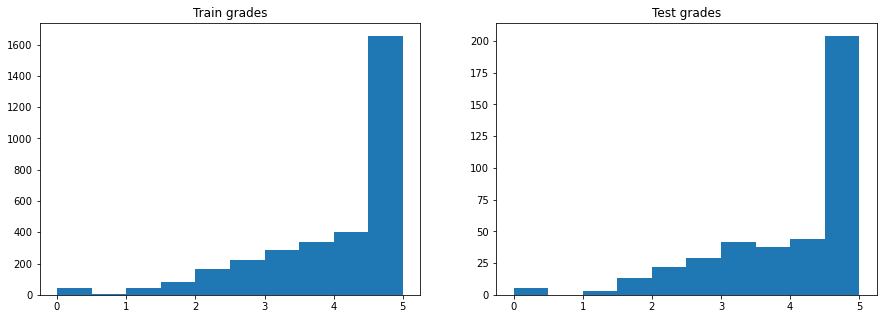

In [14]:
plt.subplot(121)
plt.hist(grade_train)
plt.title('Train grades')

plt.subplot(122)
plt.hist(grade_test)
plt.title('Test grades')

## Feature Extraction
<a id='4'><a>

### Different features were extracted and fed to a RandomForest Regressor
### It is performed on train and test sets

- Sentence embeddings for Questions, Model Answers(if exists) and Answers using SentenceBert
- Get the cosine similairty between the model answer(if exists) and answer embeddings
- Use PCA to decrease dimensionality of embeddings 
- Get words overlapped (number of common words) between the model answer(if exists) and the answer
- In case context only is available and not model answers, TF_IDF features are extracted for context and answers

In [15]:
# Load the SentenceBert model
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [16]:
def get_embeddings(sentences_list):
    
    '''
    Get sentence embeddings of the each sentence in the list using SBert
    
    Args: 
    sentences_list(ndarray): sentences to be embedded
    
    Return: 
    embeddings(ndarray): embeddings from SBert
    '''
    
    embeddings = sbert_model.encode(sentences_list)
    return embeddings

def get_word_overlap(sentences_list1, sentences_list2):
    
    '''
    Get the number of common words between each 2 pair of corresponding sentences in the lists
    
    Args: 
    sentences_list1(ndarray), sentences_list2(ndarray): 2 lists holding pairs of sentences
    
    Return: 
    overlap_list(ndarray): the number of common words between all sentences
    '''
    
    overlap_list = []
    for sent1, sent2 in zip(sentences_list1, sentences_list2):
        tokens1 = word_tokenize(sent1)
        tokens2 = word_tokenize(sent2)
        tokens1 =  set([lemmatizer.lemmatize(word) for word in tokens1 if word not in stopwords])
        tokens2 =  set([lemmatizer.lemmatize(word) for word in tokens2 if word not in stopwords])
        
        overlap = len(tokens1.intersection(tokens2))
        overlap_list.append(overlap)
    return (np.array(overlap_list))[..., np.newaxis]

def cosine_sim(vectors_list1, vectors_list2):
    
    '''
    Calculate cosine similarity between each 2 pair of corresponding vectors in the list
    
    Args: 
    vectors_list1(ndarray), vectors_list2(ndarray): 2 lists holding pairs of vectors
    
    Return: 
    similarity_matrix(ndarray): the cosine similairty between the vectors - str
    '''
    
    similarity_matrix = cosine_similarity(vectors_list1, vectors_list2)
    return np.diag(similarity_matrix)[..., np.newaxis]

In [17]:
def feature_extraction(Qs_train, model_ans_train, ans_train, 
                       Qs_test, model_ans_test, ans_test, 
                       do_pca=False, n_pca_comp=100, model_ans_exists=True, context=None, tf_idf_max_features=50):
    
    '''
    Do feature extraction to prepare the train and test features for the model
    Features extracted: 
    - Sentence embeddings using SBert for questions, model answers(if exists) and answers
    - cosine similarity between model answer(if exists) and answer embeddings
    - Number of common words between model answer(if exists) and answer
    
    Args: 
    Qs_train(ndarray):         list of train questions 
    model_ans_train(ndarray):  list of train model answers
    ans_train(ndarray):        list of train answers
    Qs_test(ndarray):          list of test questions
    model_ans_test(ndarray):   list of test model answers
    ans_test(ndarray):         list of test answers
    do_pca(boolean):           apply PCA to embeddings to reduce their dimension
    n_pca_comp(int):           number of principal components to keep for PCA
    model_ans_exists(boolean): if the model asnwers are given or not, if not, context is expected to be given
    context(str):              context about the exam/interview
    
    Return: 
    train_features(ndarray): array of concatenated train features
    test_features(ndarray):  array of concatenated train features
    pca_variance(float):     amount of variance captured in the reduced embeddings
    '''
    
    # Get embeddings
    Qs_train_embedd = get_embeddings(Qs_train)
    ans_train_embedd = get_embeddings(ans_train)
    
    Qs_test_embedd = get_embeddings(Qs_test)
    ans_test_embedd = get_embeddings(ans_test)
    
    if model_ans_exists:
        # Get model answers embeddings
        model_ans_train_embedd = get_embeddings(model_ans_train)
        model_ans_test_embedd = get_embeddings(model_ans_test)
    
        # Get cosine similairty
        cos_sim_train = cosine_sim(model_ans_train_embedd, ans_train_embedd)
        cos_sim_test = cosine_sim(model_ans_test_embedd, ans_test_embedd)
        
        # Get the number of common words between the model answer and the student's answer    
        overlap_train = get_word_overlap(model_ans_train, ans_train)
        overlap_test = get_word_overlap(model_ans_test, ans_test)
    
    else:
        # Use TF_IDF to extract important keywords from context after removing the stopwords
        context = clean_text(context)
        cleaned_context = []
        for word in word_tokenize(context):
            if word not in stopwords:
                cleaned_context.append(word)
                
        cleaned_context = "".join(cleaned_context)
        tfidf_vectorizer = TfidfVectorizer(max_features = tf_idf_max_features)
        context_tfidf = tfidf_vectorizer.fit_transform([context])
        ans_tfidf_train = tfidf_vectorizer.transform(ans_train)
        ans_tfidf_test = tfidf_vectorizer.transform(ans_test)
    
    # If PCA is True, perform dimensionality reduction
    if do_pca:
        pca = PCA(n_components = n_pca_comp)
        Qs_train_embedd = pca.fit_transform(Qs_train_embedd)
        Qs_test_embedd = pca.transform(Qs_test_embedd)
        
        ans_train_embedd = pca.fit_transform(ans_train_embedd)
        ans_test_embedd = pca.transform(ans_test_embedd)
        
        if model_ans_exists:
            model_ans_train_embedd = pca.fit_transform(model_ans_train_embedd)
            model_ans_test_embedd = pca.transform(model_ans_test_embedd)

        pca_variance = (pca.explained_variance_ratio_).sum()

    
    if model_ans_exists:
        train_features_tuple = (overlap_train, cos_sim_train, Qs_train_embedd, model_ans_train_embedd, ans_train_embedd)
        test_features_tuple = (overlap_test, cos_sim_test, Qs_test_embedd, model_ans_test_embedd, ans_test_embedd)
    else:
        train_features_tuple = (context_tfidf, ans_tfidf_train, Qs_train_embedd, ans_train_embedd)
        test_features_tuple = (context_tfidf, ans_tfidf_test, Qs_test_embedd, ans_test_embedd)

        
    # Concatenate all features into one array, for train and test
    train_features = np.concatenate(train_features_tuple, axis=-1)
    test_features = np.concatenate(test_features_tuple, axis=-1)
        
    return train_features, test_features, pca_variance

In [18]:
do_pca = True
n_pca_comp = 100
model_ans_exists = True
x_train, x_test, pca_var = feature_extraction(Qs_train, model_ans_train, ans_train,
                                              Qs_test, model_ans_test, ans_test, 
                                              do_pca, n_pca_comp, model_ans_exists)

In [19]:
print("Train features shape: ", x_train.shape)
print("Test features shape: ", x_test.shape)
if do_pca:
    print(f"PCA total variance captured using {n_pca_comp} is {pca_var*100:.2f}%")

Train features shape:  (3246, 302)
Test features shape:  (400, 302)
PCA total variance captured using 100 is 98.37%


## Score Prediction
<a id='5'><a>

In [20]:
# Instantiating a RandomForest Regressor model
random_forest = RandomForestRegressor(n_estimators=50, max_depth=15, random_state=0)

In [21]:
# Fit the model
random_forest.fit(x_train, grade_train)

# Predict on train and test set to explore if the model is overfitting, underfitting or just good
random_forest_preds_train = np.round(random_forest.predict(x_train), decimals=2)
random_forest_preds_test = np.round(random_forest.predict(x_test), decimals=2)

print("Train MAE: ", mean_absolute_error(grade_train, random_forest_preds_train))
print("Test MAE: ", mean_absolute_error(grade_test, random_forest_preds_test))

Train MAE:  0.2110751694393099
Test MAE:  0.49079999999999996


Text(0.5, 1.0, 'Predicted grades distribution')

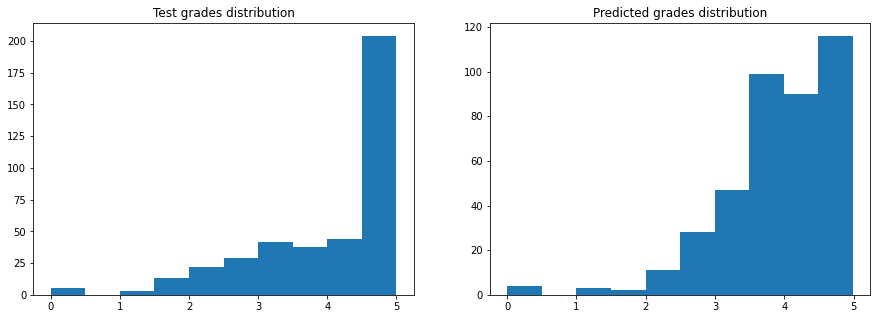

In [22]:
plt.subplot(121)
plt.hist(grade_test)
plt.title('Test grades distribution')

plt.subplot(122)
plt.hist(random_forest_preds_test)
plt.title('Predicted grades distribution')

Text(0.5, 1.0, 'Test absolute error')

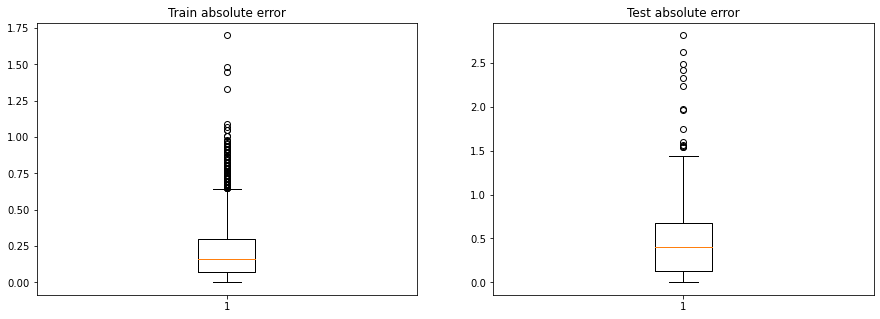

In [23]:
# Draw boxplot for absolute error of all prediction
test_abs_error = abs(random_forest_preds_test - grade_test)
train_abs_error = abs(random_forest_preds_train - grade_train)

plt.subplot(121)
plt.boxplot(train_abs_error)
plt.title('Train absolute error')

plt.subplot(122)
plt.boxplot(test_abs_error)
plt.title('Test absolute error')

In [24]:
rand_idxs = random.sample(range(0,len(grade_test)), 10)
print("Test   Predicted")
for i in rand_idxs:
    print(grade_test[i], "     ", random_forest_preds_test[i])

Test   Predicted
4.0       4.64
1.5       3.82
3.0       3.53
5.0       4.61
3.0       4.2
4.0       3.0
4.0       3.69
5.0       4.45
5.0       4.84
4.5       4.92
